<p style="font-size: 3em; font-weight: bold; margin-top: 0.5em; margin-bottom: 1em;">Data splits for BA10-18 dataset</p>

# Notes

* We use the BA10-18 (DFT-10B) dataset as hosted on the https://qmml.org website
* There is considerably less experience with this dataset than with the GDB9-14 dataset
* Differences between this dataset and the GDB9-14 dataset:
  * periodic 
  * one order of magnitude less systems
  * half as many atoms in total
  * less atoms per system
  * more chemical elements
  * only max. 2 different elements per system
* Data selection key points:
  * propery is energy of formation, that is linear part subtracted already
  * same training set sizes, but smaller validation set (1k instead of 10k)
    six training sets, sizes equi-spaced in log-space
  * stratification criteria: size (no distinction with respect to H), elements
  * systems with 5 or fewer atoms in the unit cell are excluded
  * 10 outer validation sets and outer training sets. 
    each training set is split 10 times into inner training and validation sets,
    with a ratio of 80:20

In [1]:
valsetsize = 1000
trainsetsizes = [100, 250, 650, 1600, 4000, 10000]

# Import libraries

In [2]:
import sys, os, os.path
import zipfile, bz2, csv, re
import copy, random, math
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import IPython

sys.path.insert(0, '../../../../Projects/qmmlpack/python')  # local development version
import qmmlpack as qmml

# Load dataset

In [3]:
dsfile = '../../../../Projects/QMMLPage/Source/Datasets/ba10-18.zip'

In [4]:
%%time
with zipfile.ZipFile(dsfile) as zf:  # access the downloaded .zip file
    with zf.open('ba10-18.xyz') as f:
        alloys = f.read().decode('ascii')
        alloys = qmml.import_extxyz(alloys, additional_properties=True)  # parsed data structure
    with zf.open('readme.txt') as f:
        readme = f.read().decode('ascii')

CPU times: user 853 ms, sys: 31.8 ms, total: 885 ms
Wall time: 893 ms


Properties

In [8]:
# sizes of unit cells
# alloys are not saturated, and there is therefore no difference between sizes with and without hydrogens
sizes  = np.asarray( [len(an) for an in alloys['atomic_numbers']] )

# lattice type
lattice = np.asarray( [sp[1] for sp in alloys['system_properties']])

# Formation Energy / eV
propFE = np.asfarray( [sp[3] for sp in alloys['system_properties']] )

# basis
basis = np.asfarray( alloys['additional_properties'] ) # n x 3 x 3
alloys['basis'] = basis

# eV -> meV
propFE *= 1000

# Analyse dataset

In [5]:
qmml.dataset_information(**alloys)

{'is_periodic': True,
 'num_systems': 15950,
 'num_atoms': 116420,
 'max_atoms_per_system': 8,
 'elements': array([12, 13, 22, 23, 26, 27, 28, 29, 41, 47]),
 'max_elements_per_system': 2,
 'max_same_element_per_system': 7,
 'systems_per_element': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1592, 6368,    0,    0,    0,    0,    0,    0,    0,    0,
        1592, 1592,    0,    0, 4776, 1592, 6368, 4776,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 1592,    0,    0,
           0,    0,    0, 1592,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 

## Readme

In [6]:
print(readme)


Data set ba10-18 / DFT-10B

Energies for 10*1595 binary alloy structures.

Supplementary data for

Chandramouli Nyshadham, Matthias Rupp, Brayden Bekker, Alexander V. Shapeev,
Tim Mueller, Conrad W. Rosenbrock, G{\'a}bor Cs{\'a}nyi, David W. Wingate,
Gus L.W. Hart: General Machine-Learning Surrogate Models for Materials Prediction,
arXiv 1809.09203, 2018.

Please cite above preprint if you use this dataset.

Files
-----

ba10-18.xyz - Alloys and properties in an extended XYZ format
readme.txt  - Explanations, this file

Structures
----------

10 binary alloys (AgCu, AlFe, AlMg, AlNi, AlTi, CoNi, CuFe, CuNi, FeV, NbNi)
with 10 different species and all possible face-centered cubic (fcc), body-
centered cubic (bcc) and hexagonal close-paced (hcp) structures up to 8 atoms
in the unit cell. 15,950 structures in total. Lattice parameters were set
according to Vegard's rule. Atom coordinates are given in Angstrom. The last
three lines of each structure contain the unit cell basis vectors.



## Size

Size distribution.

These alloys are not saturated with H like the molecules;
there is therefore no distinction between sizes with and without hydrogens.

In [7]:
systems_per_size = np.bincount(sizes)
print(np.asarray([np.arange(len(systems_per_size)), systems_per_size, np.cumsum(systems_per_size)], dtype=int))

[[    0     1     2     3     4     5     6     7     8]
 [    0    40    70   120   480   560  2100  2080 10500]
 [    0    40   110   230   710  1270  3370  5450 15950]]


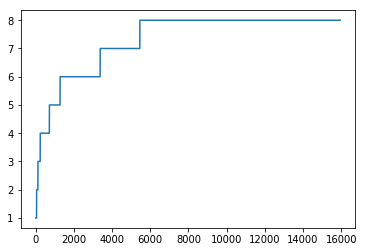

In [8]:
plt.plot( sorted(sizes) ) ; plt.show()

In analogy to the molecular dataset, we remove all systems with 5 or fewer atoms in the unit cell.

## Properties

In [9]:
np.histogram(propFE, 30)[0]

array([   8,   29,   35,   84,  160,  199,  227,  307,  437,  568,  517,
        594,  667, 1309, 3517, 2113, 1253, 1367,  891,  491,  351,  318,
        209,  198,   72,   15,    5,    4,    1,    4])

In [10]:
plt.plot(sorted(propFE)); plt.show()

# Sampling code

In [6]:
def poormanssample(size, alloys, E, indall, tolerance=0.005, minsize=200, initialbins=30, maxsteps=1000):
    """Samples a stratified subset of given size from molecules.
    
    Parameters:
      size - size of sampled subset
      alloys - dataset to sample from
      indall - valid indices in dataset to use.
      tolerance - base tolerated deviation in each statistic in percent
      minsize - minimum number of molecules required in a bin
      initialbins - number of bins to start with
      maxsteps - maximum number of steps taken
      
    Returns:
      indices of subset"""
    
    # ------- setup -------
    
    done = False           # termination condition
    iterations = 0         # iteration counter
    temperature = 0.002    # simulated annealing temperature, on a scale of fractions
    indsel = np.random.choice(indall, size, replace=False) # initial random sample
    history = np.asfarray( [[0,0,0,0,0,0]] )
    
    # statistics to consider
    # each function f(value, mols, ind) returns those positions in ind for which the statistic takes on the given value
    def fel(el, ind):
        return np.nonzero( np.asarray( [1 if el in an else 0 for an in alloys['atomic_numbers'][ind]] ) )[0]
    def fsize(s, ind):
        return np.nonzero( np.asarray( [1 if len(an) == s else 0 for an in alloys['atomic_numbers'][ind]] ) )[0]
    def fE(s, ind):
        return np.nonzero( np.asarray( [1 if s[0] <= e < s[1] else 0 for e in E[ind]] ) )[0]
    
    # statistics functions
    # these define the statistics which are compared between sample and whole dataset
    # entries are (statfunction, value, name)
    statfuns = [
        # elemental composition
        [fel, 12, 'Mg'],
        [fel, 13, 'Al'],
        [fel, 22, 'Ti'],
        [fel, 23, 'Va'],
        [fel, 26, 'Fe'],
        [fel, 27, 'Co'],
        [fel, 28, 'Ni'],
        [fel, 29, 'Cu'],
        [fel, 41, 'Nb'],
        [fel, 47, 'Ag'],
        
        # size
        # sizes up to and including 5 have been excluded
        [fsize, 6, 's-6'],
        [fsize, 7, "s-7"],
        [fsize, 8, "s-8"],
        [fsize, 9, "s-9"],
    ]

    # size statistics
    sizes = np.asarray( [len(an) for an in alloys['atomic_numbers'][indall]] )
    sbins = np.arange(max(sizes)+2)
    snums = np.full(len(sbins)-1, 0, dtype=np.int)
    for s in sizes: snums[s] += 1
    while len(snums) > 1 and min(snums) < minsize: # lump together bins that are too small
        for i in range(len(snums)):
            if snums[i] < minsize:
                if i == len(snums)-1: i = i - 1  # special case of merging last entry
                snums[i] += snums[i+1]
                snums = np.delete(snums, [i+1])
                sbins = np.delete(sbins, [i+1])
                break
    for i in range(1,len(sbins)):
        statfuns.append( [fsize, (sbins[i-1], sbins[i]), f"s-{i:2}"] )

    # energy statistics
    enums,ebins = np.histogram(E, initialbins)
    while len(enums) > 1 and min(enums) < minsize: # lump together bins that are too small
        for i in range(len(enums)):
            if enums[i] < minsize:
                if i == len(enums)-1: i = i - 1  # special case of merging last entry
                enums[i] += enums[i+1]
                enums = np.delete(enums, [i+1])
                ebins = np.delete(ebins, [i+1])
                break
    for i in range(1,len(ebins)):
        statfuns.append( [fE, (ebins[i-1], ebins[i]), f"E-{i:2}"] )

    statfuns, numstatfuns = np.asarray(statfuns), len(statfuns)
    print(f"{numstatfuns:d} statistics in total, {len(sbins):d} size bins, {len(ebins):d} energy bins.\n")
    
    # ------- Monte Carlo loop -------
    
    def step(sf, dev, aux):
        nonlocal done, indsel
        indstatall, indstatsel, pcall, pcsel, name = aux

        # check if within tolerance, correct if not
        if pcall - pcsel > tolerance: 
            # add molecule with this statistic
            done = False
            i = np.random.choice( np.setdiff1d(np.arange(size), indstatsel) ) # index of molecule without statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[indstatall], indsel) ) # add molecule with statistic
            print(f"{name:7}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> adding alloy")
        elif pcsel - pcall > tolerance: 
            # remove molecule with this statistic
            done = False
            i = np.random.choice(indstatsel)  # index of molecule with statistic
            indsel[i] = np.random.choice( np.setdiff1d(indall[np.setdiff1d(np.arange(len(indall)), indstatall)], indsel) )  # add molecule without statistic          
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> removing alloy")
        else:  
            # within tolerance, do nothing
            print(f"{name:5}: {pcall:6.2%} - {pcsel:6.2%} = {pcall-pcsel:6.2%} -> okay")

    def update_devaux():
        nonlocal deviations, auxiliary
        for i in range(numstatfuns):
            indstatall = statfuns[i,0](statfuns[i,1], indall)
            indstatsel = statfuns[i,0](statfuns[i,1], indsel)
            pcall, pcsel = len(indstatall)/len(indall), len(indstatsel)/size
            deviations[i] = max( abs(pcall-pcsel), 10**-6 )  # ensure positive probabilities
            auxiliary[i] = (indstatall, indstatsel, pcall, pcsel, statfuns[i,2])

    deviations = np.full(numstatfuns, 1, dtype=np.float)
    auxiliary = np.full((numstatfuns, 5), None, dtype=np.object)
    update_devaux()
    bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    lastdeviations, lastindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
    while not done:
        # update loop statistics
        history = np.append(history, [[np.mean(deviations), np.max(deviations), np.mean(lastdeviations), np.max(lastdeviations), np.mean(bestdeviations), np.max(bestdeviations)]], axis=0)
        lastdeviations, lastauxiliary, lastindsel = copy.deepcopy(deviations), copy.deepcopy(auxiliary), copy.deepcopy(indsel)
        iterations += 1
        done = True
        print(f"Iteration {iterations}   (best so far: {np.mean(bestdeviations):6.2%} {np.max(bestdeviations):6.2%})")
        
        # shuffle with largest deviations weighted up, then propose move
        probabilities = deviations / np.sum(deviations)
        shuffleind = np.random.choice(numstatfuns, size=numstatfuns, replace=False, p=probabilities)
        statfuns, deviations, auxiliary = statfuns[shuffleind], deviations[shuffleind], auxiliary[shuffleind]
        for sf,d,a in zip(statfuns, deviations, auxiliary):
            if not done: break
            step(sf, d, a)

        # update deviations, auxiliary
        update_devaux()
            
        # accept or reject proposed move
        if np.max(deviations) < np.max(bestdeviations) or (np.max(deviations) == np.max(bestdeviations) and np.mean(deviations) < np.mean(bestdeviations)):
            bestdeviations, bestindsel = copy.deepcopy(deviations), copy.deepcopy(indsel)
        print(f"Last: {np.mean(lastdeviations):6.2%} {np.max(lastdeviations):6.2%}.   Current: {np.mean(deviations):6.2%} {np.max(deviations):6.2%}")
        if ( np.max(deviations) > np.max(lastdeviations) ) or \
           ( np.max(deviations) == np.max(lastdeviations) and np.mean(deviations) > np.mean(lastdeviations) ):
            probability = math.exp( - ( 3 * ( np.max(deviations) - np.max(lastdeviations) ) + ( np.mean(deviations) - np.mean(lastdeviations) ) ) / temperature )
            if np.random.random() <= probability:
                print(f"Acceptance probability: {probability:6.2%} -> accepting uphill step.")
            else:
                print(f"Acceptance probability: {probability:6.2%} -> rejecting uphill step.")
                deviations, auxiliary, indsel = copy.deepcopy(lastdeviations), copy.deepcopy(lastauxiliary), copy.deepcopy(lastindsel)
        print()
        
        if iterations >= maxsteps:
            done = True

    # print last statistics again in sorted order
    sortind = np.argsort(statfuns[:,2])
    statfuns, deviations, auxiliary = statfuns[sortind], deviations[sortind], auxiliary[sortind]
    for sf,d,a in zip(statfuns, deviations, auxiliary):
        print(f"{sf[2]:5s}: {d:6.2%}")
    print()
            
    if iterations < maxsteps:
        print(f"All statistics met, done ({iterations} iterations).")
    else:
        print(f"MAXIMUM NUMBER OF {maxsteps:d} ITERATIONS REACHED, ABORTING")
    print(f"Best solution has average deviation {np.mean(bestdeviations):6.2%} and max. deviation {np.max(bestdeviations):6.2%}.")

    history = np.delete(history, 0, 0)
    history = np.delete(history, 0, 0)

    return bestindsel, bestdeviations, history

Test code:

In [53]:
valid = np.arange(len(propFE))
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if sizes[i] <= 5]))

In [ ]:
t, tdev, thist = poormanssample(1000, alloys, propFE, valid2, maxsteps=5)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

In [ ]:
t, tdev, thist = poormanssample(100, alloys, propFE, valid2, maxsteps=400)

In [ ]:
plt.plot(thist[:,0]*100, label='avg/current')
plt.plot(thist[:,1]*100, label='max/current')
plt.plot(thist[:,4]*100, label='avg/best')
plt.plot(thist[:,5]*100, label='max/best')
plt.xlabel('iterations')
plt.ylabel('deviation / %')
plt.legend()
plt.show()

# Generate subsets

In [10]:
filename = 'ba10-18-datasplits.txt'

In [16]:
def run_sampling(valid, size, key, tolerance, maxsteps):
    """Samples a data subset.
    
    Parameters:
      valid - universe of indices to choose from
      size - number of indices in sampled subset
      key - string name of the sampled subset
      tolerance - tolerated deviation from whole-set statistics
      maxsteps - maximum number of Monte Carlo steps
    """
    # run sampling
    ind, dev, hist = poormanssample(size, alloys, propFE, valid, tolerance=tolerance, maxsteps=maxsteps)

    # write results to file, appending
    with open(filename, 'ta', encoding='ascii') as f:
        f.write(key + ':' + ' '.join([str(i) for i in ind]) + '\n')
        
    # visualize optimization
    plt.plot(hist[:,0]*100, label='avg/current')
    plt.plot(hist[:,1]*100, label='max/current')
    plt.plot(hist[:,4]*100, label='avg/best')
    plt.plot(hist[:,5]*100, label='max/best')
    plt.xlabel('iterations')
    plt.ylabel('deviation / %')
    plt.legend()
    plt.show()

In [6]:
def load_data_splits(filename):
    with open(filename, 'rt') as f:
        raw = f.read()
    res = {}
    for line in raw.split('\n'):
        if len(line.strip()) == 0: continue
        key, data = line.split(':')
        data = np.asarray( [int(i) for i in data.split()], dtype=int )
        res[key] = data

    return res

## Validation sets

In [9]:
valid = np.arange(len(propFE))  # all samples are valid
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if sizes[i] <= 5]))

In [11]:
%%time
run_sampling(valid2, valsetsize, 'ov-1', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.52%  2.03%)
Co     : 10.00% -  9.00% =  1.00% -> adding alloy
Last:  0.52%  2.03%.   Current:  0.51%  1.93%

...

Iteration 202   (best so far:  0.07%  0.15%)
E- 5 :  3.66% -  3.80% = -0.14% -> okay
Ti   : 10.00% - 10.10% = -0.10% -> okay
E-13 :  8.87% -  8.80% =  0.07% -> okay
E-11 : 13.11% - 13.20% = -0.09% -> okay
E- 9   :  7.85% -  7.70% =  0.15% -> adding alloy
Last:  0.07%  0.15%.   Current:  0.06%  0.14%

Iteration 203   (best so far:  0.06%  0.14%)
Co   : 10.00% - 10.10% = -0.10% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
Ti   : 10.00% - 10.10% = -0.10% -> okay
E- 3 :  2.02% -  2.10% = -0.08% -> okay
E-10 : 21.33% - 21.40% = -0.07% -> okay
E-16 :  2.34% -  2.20% =  0.14% -> okay
E- 7 :  3.48% -  3.60% = -0.12% -> okay
E- 5 :  3.66% -  3.80% = -0.14% -> okay
E- 6 :  3.29% -  3.40% = -0.11% -> okay
Fe   : 30.00% - 30.10% = -0.10% -> okay
E-15 :  3.19% -  3.20% = -0.01% -> okay
E-17 :  2.15% 

In [13]:
%%time
run_sampling(valid2, valsetsize, 'ov-2', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.53%  2.60%)
Fe     : 30.00% - 29.80% =  0.20% -> adding alloy
Last:  0.53%  2.60%.   Current:  0.52%  2.60%

...

Iteration 214   (best so far:  0.07%  0.19%)
E-17 :  2.15% -  2.20% = -0.05% -> okay
Ag     : 10.00% -  9.80% =  0.20% -> adding alloy
Last:  0.07%  0.20%.   Current:  0.06%  0.14%

Iteration 215   (best so far:  0.06%  0.14%)
E- 7 :  3.48% -  3.60% = -0.12% -> okay
E- 6 :  3.29% -  3.20% =  0.09% -> okay
E-10 : 21.33% - 21.40% = -0.07% -> okay
E- 9 :  7.85% -  7.80% =  0.05% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
Co   : 10.00% - 10.10% = -0.10% -> okay
E-16 :  2.34% -  2.40% = -0.06% -> okay
E-17 :  2.15% -  2.20% = -0.05% -> okay
Mg   : 10.00% - 10.10% = -0.10% -> okay
Ti   : 10.00% -  9.90% =  0.10% -> okay
s-6  : 14.31% - 14.20% =  0.11% -> okay
E-14 :  5.84% -  5.80% =  0.04% -> okay
E- 1 :  2.15% -  2.10% =  0.05% -> okay
E- 5 :  3.66% -  3.80% = -0.14% -> okay
E-18 :  1.42% 

In [15]:
%%time
run_sampling(valid2, valsetsize, 'ov-3', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.59%  2.43%)
Co     : 10.00% -  9.80% =  0.20% -> adding alloy
Last:  0.59%  2.43%.   Current:  0.58%  2.33%

...

Iteration 380   (best so far:  0.06%  0.17%)
E- 1 :  2.15% -  2.30% = -0.15% -> okay
s-6  : 14.31% - 14.20% =  0.11% -> okay
Fe   : 30.00% - 29.90% =  0.10% -> okay
E-13 :  8.87% -  9.00% = -0.13% -> okay
E-18 :  1.42% -  1.30% =  0.12% -> okay
Nb   : 10.00% - 10.10% = -0.10% -> okay
E-11 : 13.11% - 13.30% = -0.19% -> removing alloy
Last:  0.07%  0.19%.   Current:  0.06%  0.15%

Iteration 381   (best so far:  0.06%  0.15%)
Co   : 10.00% - 10.10% = -0.10% -> okay
E-13 :  8.87% -  9.00% = -0.13% -> okay
E-11 : 13.11% - 13.20% = -0.09% -> okay
s-7  : 14.17% - 14.30% = -0.13% -> okay
s-6  : 14.31% - 14.20% =  0.11% -> okay
Fe   : 30.00% - 29.90% =  0.10% -> okay
E-19 :  2.03% -  1.90% =  0.13% -> okay
E- 2 :  2.87% -  3.00% = -0.13% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
E-15 :  3.19% 

In [23]:
%%time
run_sampling(valid2, valsetsize, 'ov-4', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.47%  1.60%)
E-16   :  2.34% -  1.80% =  0.54% -> adding alloy
Last:  0.47%  1.60%.   Current:  0.48%  1.70%
Acceptance probability: 21.86% -> rejecting uphill step.

...

Iteration 305   (best so far:  0.07%  0.15%)
E-11 : 13.11% - 13.20% = -0.09% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
Mg   : 10.00% -  9.90% =  0.10% -> okay
E- 4 :  2.89% -  2.80% =  0.09% -> okay
Ti   : 10.00% - 10.10% = -0.10% -> okay
E- 6 :  3.29% -  3.20% =  0.09% -> okay
E-16 :  2.34% -  2.20% =  0.14% -> okay
Va   : 10.00% -  9.90% =  0.10% -> okay
E-12 :  7.62% -  7.70% = -0.08% -> okay
E-18 :  1.42% -  1.30% =  0.12% -> okay
E- 1 :  2.15% -  2.30% = -0.15% -> okay
E-14 :  5.84% -  5.80% =  0.04% -> okay
E-10 : 21.33% - 21.40% = -0.07% -> okay
s-7  : 14.17% - 14.30% = -0.13% -> okay
Co   : 10.00% - 10.10% = -0.10% -> okay
s-8  : 71.53% - 71.40% =  0.13% -> okay
Cu   : 30.00% - 29.90% =  0.10% -> okay
Fe   : 30.00% - 30.

In [24]:
%%time
run_sampling(valid2, valsetsize, 'ov-5', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.41%  1.48%)
E-16   :  2.34% -  2.10% =  0.24% -> adding alloy
Last:  0.41%  1.48%.   Current:  0.41%  1.48%

...

Iteration 233   (best so far:  0.07%  0.20%)
E-12 :  7.62% -  7.50% =  0.12% -> okay
E-17 :  2.15% -  2.30% = -0.15% -> okay
Co   : 10.00% - 10.10% = -0.10% -> okay
s-8  : 71.53% - 71.40% =  0.13% -> okay
E- 3 :  2.02% -  1.90% =  0.12% -> okay
E- 4 :  2.89% -  2.80% =  0.09% -> okay
E- 8 :  3.85% -  3.70% =  0.15% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
E- 5 :  3.66% -  3.60% =  0.06% -> okay
E- 6 :  3.29% -  3.40% = -0.11% -> okay
E-16 :  2.34% -  2.40% = -0.06% -> okay
E-18 :  1.42% -  1.30% =  0.12% -> okay
Nb   : 10.00% -  9.90% =  0.10% -> okay
E-10 : 21.33% - 21.40% = -0.07% -> okay
Fe     : 30.00% - 29.80% =  0.20% -> adding alloy
Last:  0.07%  0.20%.   Current:  0.07%  0.15%

Iteration 234   (best so far:  0.07%  0.15%)
E- 3 :  2.02% -  1.90% =  0.12% -> okay
Co   : 10.00% 

In [25]:
%%time
run_sampling(valid2, valsetsize, 'ov-6', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.49%  2.37%)
Al     : 40.00% - 39.40% =  0.60% -> adding alloy
Last:  0.49%  2.37%.   Current:  0.48%  2.27%

...

Iteration 169   (best so far:  0.05%  0.17%)
E-11 : 13.11% - 13.20% = -0.09% -> okay
E-14 :  5.84% -  5.70% =  0.14% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
E-19 :  2.03% -  2.20% = -0.17% -> removing alloy
Last:  0.05%  0.17%.   Current:  0.05%  0.14%

Iteration 170   (best so far:  0.05%  0.14%)
E- 6 :  3.29% -  3.40% = -0.11% -> okay
Cu   : 30.00% - 30.10% = -0.10% -> okay
E-19 :  2.03% -  2.10% = -0.07% -> okay
E-14 :  5.84% -  5.70% =  0.14% -> okay
s-7  : 14.17% - 14.20% = -0.03% -> okay
E-13 :  8.87% -  9.00% = -0.13% -> okay
E- 3 :  2.02% -  2.00% =  0.02% -> okay
E-11 : 13.11% - 13.20% = -0.09% -> okay
E-10 : 21.33% - 21.20% =  0.13% -> okay
E-15 :  3.19% -  3.30% = -0.11% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
E-12 :  7.62% -  7.60% =  0.02% -> okay
E- 2 :  2.87% 

In [26]:
%%time
run_sampling(valid2, valsetsize, 'ov-7', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.53%  2.13%)
E-17   :  2.15% -  1.70% =  0.45% -> adding alloy
Last:  0.53%  2.13%.   Current:  0.52%  2.13%

...

Iteration 248   (best so far:  0.07%  0.15%)
Va   : 10.00% - 10.10% = -0.10% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
E- 5 :  3.66% -  3.70% = -0.04% -> okay
E-17 :  2.15% -  2.30% = -0.15% -> okay
Cu   : 30.00% - 29.90% =  0.10% -> okay
E-11 : 13.11% - 13.00% =  0.11% -> okay
Ti   : 10.00% - 10.10% = -0.10% -> okay
Mg   : 10.00% - 10.10% = -0.10% -> okay
E- 2 :  2.87% -  2.80% =  0.07% -> okay
E-16 :  2.34% -  2.30% =  0.04% -> okay
s-8  : 71.53% - 71.50% =  0.03% -> okay
E- 1 :  2.15% -  2.30% = -0.15% -> okay
E-18 :  1.42% -  1.50% = -0.08% -> okay
E-14 :  5.84% -  5.70% =  0.14% -> okay
E- 4 :  2.89% -  3.00% = -0.11% -> okay
E-12 :  7.62% -  7.60% =  0.02% -> okay
E-10 : 21.33% - 21.20% =  0.13% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
Ni   : 40.00% - 39.90% =  0.10% -> o

In [27]:
%%time
run_sampling(valid2, valsetsize, 'ov-8', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.63%  2.10%)
E- 3 :  2.02% -  3.00% = -0.98% -> removing alloy
Last:  0.63%  2.10%.   Current:  0.63%  2.10%

...

Iteration 290   (best so far:  0.06%  0.20%)
E-15 :  3.19% -  3.30% = -0.11% -> okay
s-6  : 14.31% - 14.40% = -0.09% -> okay
E-10 : 21.33% - 21.20% =  0.13% -> okay
E- 5 :  3.66% -  3.60% =  0.06% -> okay
E-13 :  8.87% -  9.00% = -0.13% -> okay
E-16 :  2.34% -  2.40% = -0.06% -> okay
E- 6 :  3.29% -  3.40% = -0.11% -> okay
E-14 :  5.84% -  5.70% =  0.14% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
s-8  : 71.53% - 71.40% =  0.13% -> okay
Cu   : 30.00% - 30.10% = -0.10% -> okay
E- 1 :  2.15% -  2.10% =  0.05% -> okay
E- 4 :  2.89% -  2.80% =  0.09% -> okay
Mg   : 10.00% - 10.10% = -0.10% -> okay
E- 2 :  2.87% -  2.90% = -0.03% -> okay
E-17 :  2.15% -  2.30% = -0.15% -> okay
Nb   : 10.00% - 10.10% = -0.10% -> okay
Ni   : 40.00% - 39.90% =  0.10% -> okay
Fe   : 30.00% - 30.10% = -0.10% -> o

In [28]:
%%time
run_sampling(valid2, valsetsize, 'ov-9', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.69%  3.70%)
Ni     : 40.00% - 38.20% =  1.80% -> adding alloy
Last:  0.69%  3.70%.   Current:  0.70%  3.60%

...

Iteration 378   (best so far:  0.06%  0.15%)
E-19 :  2.03% -  1.90% =  0.13% -> okay
s-7  : 14.17% - 14.30% = -0.13% -> okay
E-10 : 21.33% - 21.20% =  0.13% -> okay
E- 5 :  3.66% -  3.70% = -0.04% -> okay
E-16 :  2.34% -  2.20% =  0.14% -> okay
E- 9 :  7.85% -  8.00% = -0.15% -> okay
s-8  : 71.53% - 71.40% =  0.13% -> okay
Co   : 10.00% -  9.90% =  0.10% -> okay
E- 1 :  2.15% -  2.30% = -0.15% -> okay
Va   : 10.00% - 10.10% = -0.10% -> okay
E- 7 :  3.48% -  3.50% = -0.02% -> okay
E-11 : 13.11% - 13.20% = -0.09% -> okay
E-12 :  7.62% -  7.70% = -0.08% -> okay
Al   : 40.00% - 40.10% = -0.10% -> okay
Ni   : 40.00% - 40.10% = -0.10% -> okay
E-13 :  8.87% -  8.90% = -0.03% -> okay
E- 3 :  2.02% -  2.00% =  0.02% -> okay
E-14 :  5.84% -  5.80% =  0.04% -> okay
E-17 :  2.15% -  2.10% =  0.05% -> o

In [29]:
%%time
run_sampling(valid2, valsetsize, 'ov-10', 0.0015, 2500)

36 statistics in total, 4 size bins, 20 energy bins.

Iteration 1   (best so far:  0.96%  3.50%)
E-10 : 21.33% - 22.60% = -1.27% -> removing alloy
Last:  0.96%  3.50%.   Current:  0.97%  3.60%
Acceptance probability: 21.11% -> accepting uphill step.

...

Iteration 501   (best so far:  0.06%  0.15%)
E-13 :  8.87% -  8.80% =  0.07% -> okay
Nb   : 10.00% - 10.10% = -0.10% -> okay
E-11 : 13.11% - 13.20% = -0.09% -> okay
E- 4 :  2.89% -  3.00% = -0.11% -> okay
E- 6 :  3.29% -  3.40% = -0.11% -> okay
Al   : 40.00% - 39.90% =  0.10% -> okay
E- 1 :  2.15% -  2.30% = -0.15% -> okay
Va   : 10.00% -  9.90% =  0.10% -> okay
E-12 :  7.62% -  7.60% =  0.02% -> okay
E-19 :  2.03% -  2.00% =  0.03% -> okay
Ag   : 10.00% -  9.90% =  0.10% -> okay
E-14 :  5.84% -  5.80% =  0.04% -> okay
s-7  : 14.17% - 14.20% = -0.03% -> okay
E- 5 :  3.66% -  3.80% = -0.14% -> okay
E-10 : 21.33% - 21.40% = -0.07% -> okay
E-16 :  2.34% -  2.20% =  0.14% -> okay
E-15 :  3.19% -  3.20% = -0.01% -> okay
E- 9 :  7.85% -  7.

## Outer training sets and internal splits

In [11]:
inds = load_data_splits(filename)
valid = np.arange(len(propFE))  # all samples are valid
valid2 = np.setdiff1d(valid, np.asarray([i for i in valid if sizes[i] <= 5]))
valid3 = [np.setdiff1d(valid2, inds['ov-' + s]) for s in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']]

### Outer training sets

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 100, 'ot-' + str(i+1) + '-100', 0.01, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 250, 'ot-' + str(i+1) + '-250', 0.005, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 650, 'ot-' + str(i+1) + '-650', 0.0025, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 1600, 'ot-' + str(i+1) + '-1600', 0.001, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 4000, 'ot-' + str(i+1) + '-4000', 0.0005, 5000)

In [ ]:
%%time
for i in range(10):
    run_sampling(valid3[i], 10000, 'ot-' + str(i+1) + '-10000', 0.00025, 5000)

### Inner splits

In [ ]:
%%time
for i in range(10):
    for j in range(10):
        run_sampling(inds['ot-' + str(i+1) + '-100'], 20, 'iv-' + str(i+1) + '-100-' + str(j+1), 0.05, 2500)

In [ ]:
%%time
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-250'], 50, 'iv-' + str(i+1) + '-250-' + str(j+1), 0.025, 2500)

In [ ]:
%%time
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-650'], 130, 'iv-' + str(i+1) + '-650-' + str(j+1), 0.01, 2500)

In [ ]:
%%time
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-1600'], 320, 'iv-' + str(i+1) + '-1600-' + str(j+1), 0.005, 2500)

In [14]:
%%time
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-4000'], 800, 'iv-' + str(i+1) + '-4000-' + str(j+1), 0.0025, 2500)

In [ ]:
%%time
for i in range(10):
    for j in range(10):
        print('split ' + str(i+1) + '-' + str(j+1) + '\n')
        run_sampling(inds['ot-' + str(i+1) + '-10000'], 2000, 'iv-' + str(i+1) + '-10000-' + str(j+1), 0.001, 2500)

# Validation of sampled subsets

continue here

In [8]:
valsetsize = 1000
trainsetsizes = [100, 250, 650, 1600, 4000, 10000]

In [12]:
toosmall = np.asarray([i for i in valid if sizes[i] <= 5])
inds = load_data_splits(filename)

numov, numiv = 10, 10

ovkeys = [k for k in inds.keys() if re.fullmatch('ov-\d+', k)]
otkeys = [k for k in inds.keys() if re.fullmatch('ot-\d+-\d+', k)]
ivkeys = [k for k in inds.keys() if re.fullmatch('iv-\d+-\d+-\d+', k)]

assert len(ovkeys) == numov, "all outer validation subsets present"
assert len(otkeys) == numov * len(trainsetsizes), "all training subsets present"
assert len(ivkeys) == numov * len(trainsetsizes) * numiv, "all inner splits present"

print(f"{len(ovkeys):d} outer splits.")
for ov in sorted(ovkeys):
    ovi = ov.split('-')[1]  # index of outer validation set
    
    assert np.unique(inds[ov]).size == inds[ov].size, 'unique entries'
    assert np.intersect1d(inds[ov], toosmall).size == 0, 'excluded due to size'
    print(f"outer validation set {ov} passed.")
    
    for ot in sorted(otkeys):
        oti, otj = ot.split('-')[1:3]  # outer training set indices (ov, tss)
        if oti != ovi: continue

        assert np.unique(inds[ot]).size == inds[ot].size, 'unique entries'
        assert np.intersect1d(inds[ot], toosmall).size == 0, 'excluded due to size'
        assert np.intersect1d(inds[ot], inds['ov-'+oti]).size == 0, "no overlap between training and validation set"
        print(f"    outer training set {ot} passed.")
        
        for iv in sorted(ivkeys):
            ivi, ivj, ivk = iv.split('-')[1:4]
            if ivi != ovi: continue
            if ivj != otj: continue
            
            assert np.unique(inds[iv]).size == inds[iv].size, 'unique entries'
            assert np.in1d(inds[iv], inds[ot]).all(), "split is subset of outer training set"
            assert inds[iv].size == round(inds[ot].size * 0.2), "correct size"
            print(f"        inner validation set {iv} passed.")
            
print("All checks passed.")

10 outer splits.
outer validation set ov-1 passed.
    outer training set ot-1-100 passed.
        inner validation set iv-1-100-1 passed.
        inner validation set iv-1-100-10 passed.
        inner validation set iv-1-100-2 passed.
        inner validation set iv-1-100-3 passed.
        inner validation set iv-1-100-4 passed.
        inner validation set iv-1-100-5 passed.
        inner validation set iv-1-100-6 passed.
        inner validation set iv-1-100-7 passed.
        inner validation set iv-1-100-8 passed.
        inner validation set iv-1-100-9 passed.
    outer training set ot-1-10000 passed.
        inner validation set iv-1-10000-1 passed.
        inner validation set iv-1-10000-10 passed.
        inner validation set iv-1-10000-2 passed.
        inner validation set iv-1-10000-3 passed.
        inner validation set iv-1-10000-4 passed.
        inner validation set iv-1-10000-5 passed.
        inner validation set iv-1-10000-6 passed.
        inner validation set iv-1-1

        inner validation set iv-6-650-3 passed.
        inner validation set iv-6-650-4 passed.
        inner validation set iv-6-650-5 passed.
        inner validation set iv-6-650-6 passed.
        inner validation set iv-6-650-7 passed.
        inner validation set iv-6-650-8 passed.
        inner validation set iv-6-650-9 passed.
outer validation set ov-7 passed.
    outer training set ot-7-100 passed.
        inner validation set iv-7-100-1 passed.
        inner validation set iv-7-100-10 passed.
        inner validation set iv-7-100-2 passed.
        inner validation set iv-7-100-3 passed.
        inner validation set iv-7-100-4 passed.
        inner validation set iv-7-100-5 passed.
        inner validation set iv-7-100-6 passed.
        inner validation set iv-7-100-7 passed.
        inner validation set iv-7-100-8 passed.
        inner validation set iv-7-100-9 passed.
    outer training set ot-7-10000 passed.
        inner validation set iv-7-10000-1 passed.
        inner val